In [1]:
import numpy as np
import pandas as pd
from numpy import array

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [3]:
look_back = 8
data=pd.read_csv('oil_train.csv')
dataset = np.asarray(data[['Price']])
scaler = MinMaxScaler(feature_range=(0, 1))
x_sample = [8, 150]
scaler.fit(np.array(x_sample)[:, np.newaxis])
#dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.9)
test_size = len(dataset) - train_size
trainx, testy = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train=scaler.transform(trainx)
test=scaler.transform(testy)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print(len(testX),len(testY))

833 833


In [4]:

batch_size = 16
model = Sequential()
#model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(look_back, 1)))
#model.add(Dropout(0.7))
model.add(LSTM(32, activation='relu',return_sequences=True))
model.add(LSTM(16, activation='relu'))
#model.add(Dropout(0.7))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [12]:
%%time
history=model.fit(trainX, trainY, epochs=8, batch_size=batch_size,validation_data=(testX, testY), shuffle=False)

Train on 7559 samples, validate on 833 samples
Epoch 1/8
7559/7559 [==============================] - 28s 4ms/step - loss: 0.0023 - val_loss: 0.0128
Epoch 2/8
7559/7559 [==============================] - 27s 4ms/step - loss: 0.0022 - val_loss: 0.0118
Epoch 3/8
7559/7559 [==============================] - 27s 4ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 4/8
7559/7559 [==============================] - 27s 4ms/step - loss: 0.0017 - val_loss: 0.0097
Epoch 5/8
7559/7559 [==============================] - 27s 4ms/step - loss: 0.0016 - val_loss: 0.0089
Epoch 6/8
7559/7559 [==============================] - 28s 4ms/step - loss: 0.0016 - val_loss: 0.0080
Epoch 7/8
7559/7559 [==============================] - 30s 4ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 8/8
7559/7559 [==============================] - 30s 4ms/step - loss: 0.0014 - val_loss: 0.0056
Wall time: 3min 44s


In [13]:
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
#print(testX[:252])
print('Test Score: ', testScore)

Train Score:  0.01202966585350428
Test Score:  0.0056265970577186715


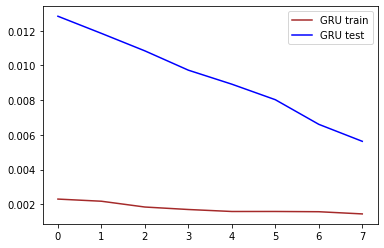

In [14]:
plt.plot(history.history['loss'], label='GRU train', color='brown')
plt.plot(history.history['val_loss'], label='GRU test', color='blue')
plt.legend()
plt.show()

In [15]:
input=test[test_size-look_back:]
r_data=pd.read_csv('oil_july.csv').values
size=r_data.size
predicted_y=[]
for i in range(size):
    #print(input)
    input_lstm=np.reshape(input[i:look_back+i],newshape=1*look_back)
    input_lstm=np.reshape(input_lstm, (1,look_back,1))
    #print(input_lstm)
    y=model.predict(input_lstm,verbose=0)
    #print(y)
    input=np.append(input,y[0])
    y=scaler.inverse_transform(y)
    predicted_y.append(y[0])
    #print(predicted_y)
    #i=i+1

#print(scaler.transform(r_data))

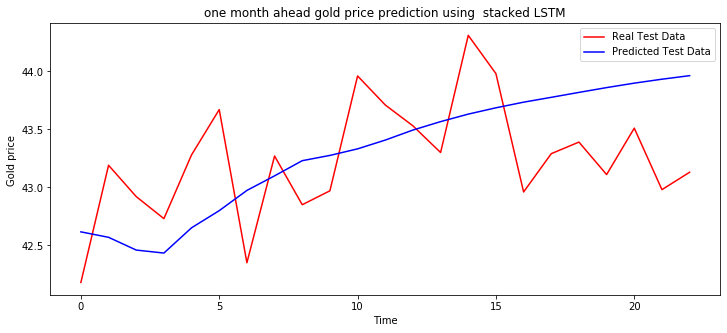

In [16]:
plt.figure(figsize=(12,5))
plt.plot(r_data, color = 'red', label = 'Real Test Data')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Test Data')
plt.title('one month ahead gold price prediction using  stacked LSTM')
plt.xlabel('Time')
plt.ylabel('Gold price ')
plt.legend()
plt.show()


In [17]:
input=test[test_size-look_back:]
r_data=pd.read_csv('oil_july.csv').values
size=r_data.size
predicted_1y=[]
for i in range(size):
    #print(input)
    input_lstm=np.reshape(input[i:look_back+i],newshape=1*look_back)
    input_lstm=np.reshape(input_lstm, (1,look_back,1))
    #print(input_lstm)
    y=model.predict(input_lstm,verbose=0)
    x=scaler.transform([r_data[i]])
    input=np.append(input,x)
    y=scaler.inverse_transform(y)
    predicted_1y.append(y[0])
    #print(predicted_y)
    #i=i+1

#print(scaler.transform(r_data))

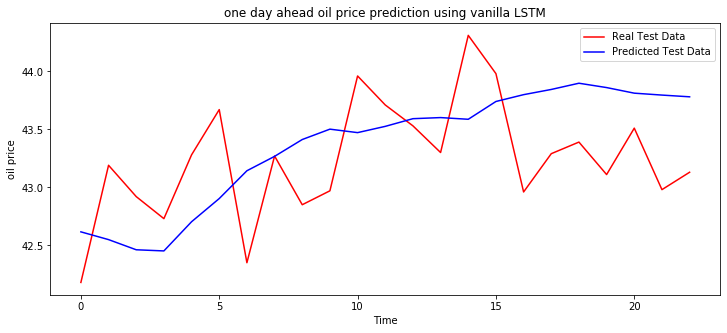

In [18]:
plt.figure(figsize=(12,5))
plt.plot(r_data, color = 'red', label = 'Real Test Data')
plt.plot(predicted_1y, color = 'blue', label = 'Predicted Test Data')
plt.title('one day ahead oil price prediction using vanilla LSTM')
plt.xlabel('Time')
plt.ylabel('oil price')
plt.legend()
plt.show()

In [19]:
import pickle
filename = 'stack_lstm_oil.sav'
pickle.dump(model, open(filename, 'wb'))